In [1]:
# %pip install torch
# %pip install torchsummary

import torch
# from torchsummary import summary

print(f'available devices: {torch.cuda.device_count()}')
print(f'cuda is available: {torch.cuda.is_available()}')
!which python
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


available devices: 0
cuda is available: False
/home/xhosta/anaconda3/bin/python


In [3]:
%pip install imutils

import os
import re
import cv2

import math
import  importlib # for refreshing import(nets.py)
import numpy as np
import matplotlib.pyplot as plt

# generate
from imutils import rotate_bound
from math import ceil
from random import randint, shuffle

# files
import utils 
import nets 
import dataset 

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [14]:
# Load the dataset

train_data_path= "../../data/imgs/BPdata/test"
def getImgs(path):
    IN_paths=[]
    GT_paths=[]
    gauss_paths=[]
    salt_paths=[]
    for root, dirs, files in os.walk(path):
        for name in files:
            path2file=os.path.join(root,name)
            if re.findall('gauss.*\.jpg', path2file):
                gauss_paths.append(path2file)
            if re.findall('salt.*\.jpg', path2file):
                salt_paths.append(path2file)
            if re.findall('IN.*\.jpg', path2file):
                IN_paths.append(path2file)
            if re.findall('.tif', path2file):
                GT_paths.append(path2file)
      # break
    return IN_paths, GT_paths, gauss_paths, salt_paths

IN_paths, GT_paths, gauss_paths, salt_paths= getImgs(train_data_path)
            
if not IN_paths:
    print("err loading ",train_data_path)
else:
    print(len(IN_paths))
    print(len(GT_paths))
    print(len(gauss_paths))
    print(len(salt_paths))

450
450
0
0


../../data/imgs/BPdata/test/IN/14particles_2.jpg
(14, 8)


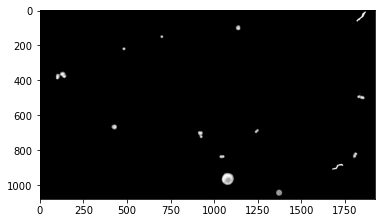

0.97
0.75
0.97
32.64
836.50
110.67
17.14
0.00


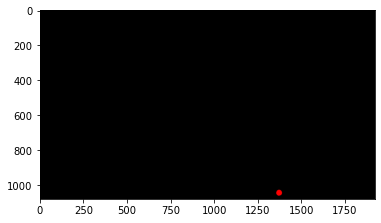

0.99
0.76
0.98
67.42
3570.50
230.75
35.48
0.00


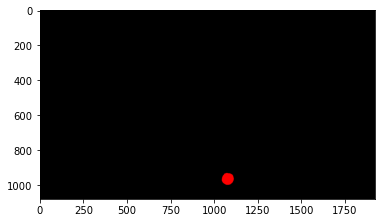

0.27
0.23
0.51
24.20
460.00
168.57
32.96
0.00


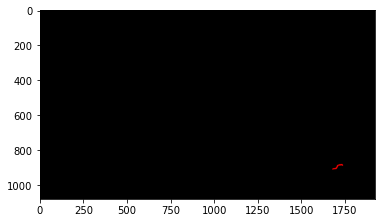

0.63
0.72
0.95
21.54
364.50
76.87
13.95
0.00


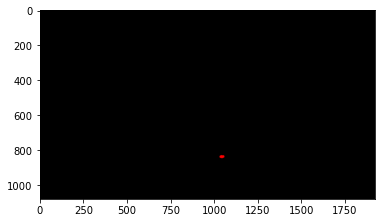

0.57
0.62
0.93
23.70
441.00
88.43
16.57
0.00


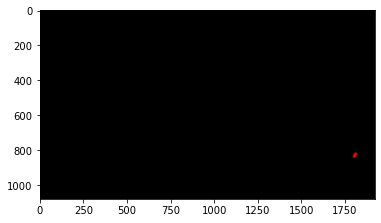

0.66
0.69
0.92
29.77
696.00
117.25
20.82
0.00


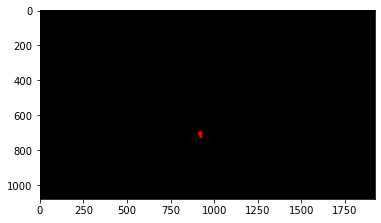

0.55
0.59
0.95
18.66
273.50
67.36
12.62
0.00


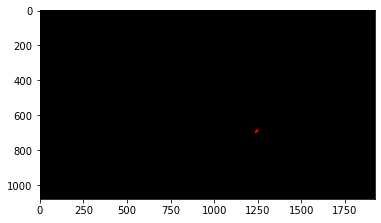

0.90
0.77
0.98
28.12
621.00
94.77
15.55
0.00


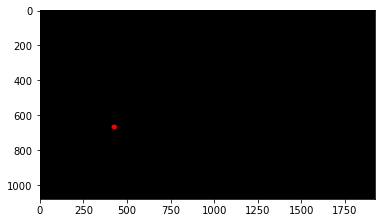

0.44
0.61
0.89
27.12
577.50
108.67
20.62
0.00


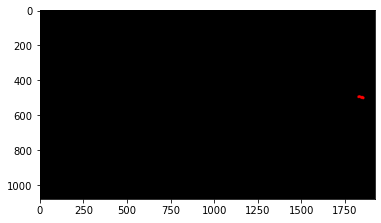

0.61
0.54
0.75
41.64
1361.50
203.78
30.40
0.00


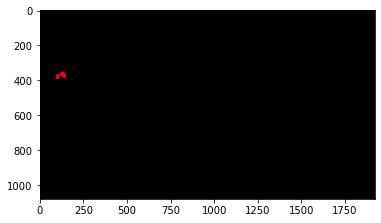

0.88
0.74
0.97
15.45
187.50
52.38
8.76
0.00


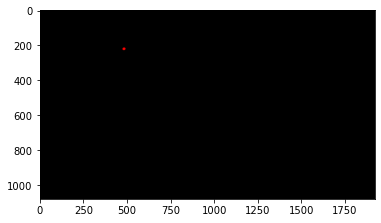

0.93
0.74
0.97
14.03
154.50
47.56
8.06
0.00


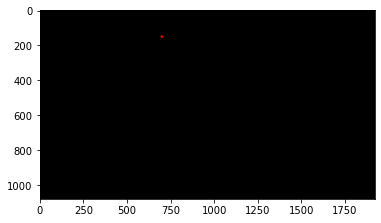

0.89
0.77
0.98
26.20
539.00
86.77
14.59
0.00


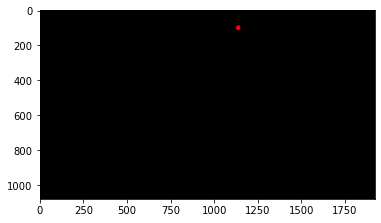

0.20
0.20
0.72
27.79
606.50
171.24
37.17
0.00


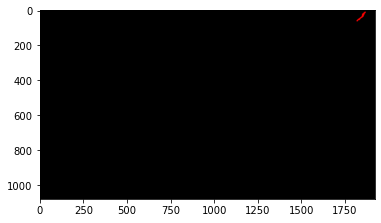

IndexError: index 14 is out of bounds for axis 0 with size 14

In [34]:
importlib.reload(utils)

def featuresFromImage(image):
    featuresArray = []
#     contImgs=[]
    imageMask = utils.getMask(image,threshold=100,kernelSize=5) 
    contours = cv2.findContours(imageMask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE) # img, contours, hierarchy

    labelsCount, _, values, centroids=  cv2.connectedComponentsWithStats(imageMask) 
#     print(labelsCount, values.shape, centroids.shape)
    contoursImg = np.zeros(image.shape, dtype=np.uint8)
    trainFeatures= []

    for i,cnt in enumerate(contours[0]): # iterate through contours
#         if  i > 0:  # skip background (and small dust cv2.arcLength(contour, closed=True) < 50)
            contour = cnt.squeeze()

            features = utils.extractFeaturesFromContour(contour)
            contoursImg=np.zeros(contoursImg.shape,dtype=np.uint8)
#             contoursImg = cv2.drawContours(contoursImg, contours[0],i,(255,0,0), thickness=cv2.FILLED)
            featuresArray.append(features)
            contImgs.append(contoursImg)
    return np.array(featuresArray)#, contImgs

idx=3
image  = cv2.imread(IN_paths[idx])
cvs0= featuresFromImage(image)
print( IN_paths[idx])
print( cvs0.shape)

plt.imshow(image)
plt.show()
for i,im in enumerate(contImgs):
    [print("{:.2f}".format(z)) for z in cvs0[i]]
    plt.imshow(im)
    plt.show()
# plot_intensity_histogram(image) 
#     area = cv2.contourArea(contour)
#     cntLen = cv2.arcLength(contour, closed=True)
#     _,radius = cv2.minEnclosingCircle(contour)
#     _,_,wBB,hBB = cv2.boundingRect(contour)
#     k = cv2.isContourConvex(contour)

#     rectMinRatio  # height & width of min rectangle
#     extent # cnt area / BBox area
#     solidity # cnt area / k hull area
#     equi_diameter # diameter of a circle with the same
# ([rectMinRatio, extent, solidity, equi_diameter, area, cntLen, radius, k]

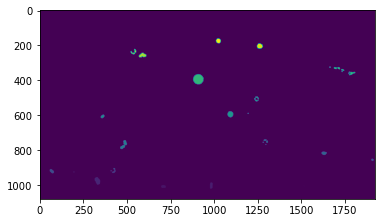

39
(1080, 1920)


In [18]:
image = cv2.imread(wafer_img_paths[0])
imageMask = utils.getMask(image,threshold=100,kernelSize=5) 
# listContours = markContours(imageMask) 
imgContours = utils.img2segmented(imageMask)

plt.imshow(imgContours)
plt.show()
a=np.unique(imgContours)
print(len(a))
print(imgContours.shape)
# TODO check 32.jpg

In [19]:

importlib.reload(nets)
importlib.reload(utils)

batch_size=2
ds=[]
targets=[]
weights=[]
for idx, img in enumerate(wafer_img_paths):
    if idx >= batch_size:
        break
        
    image = cv2.imread(img)
    image = cv2.resize(image, dsize=( 1920,1088), interpolation=cv2.INTER_CUBIC)
    imgContoursBinary = utils.getMask(image,threshold=100,kernelSize=5)
    imgContoursSlices = np.array(utils.markContours(imgContoursBinary))
#     imgContours = img2segmented(getMask(image,threshold=100,kernelSize=5) )
    weightImg= utils.distanceMap(imgContoursBinary)
    
    ds.append(image)
    targets.append(imgContoursBinary) # imgContours
    weights.append(weightImg)
dataS=np.array(ds)
targetS=np.array(targets)
weightS=np.array(targets)

print("model input shape:",dataS[0].shape)
print("model GT shape:",targetS[0].shape)

model input shape: (1088, 1920, 3)
model GT shape: (1088, 1920)


In [20]:
import torch.optim as optim
from torch.cuda.amp import autocast, GradScaler

importlib.reload(nets)
importlib.reload(dataset)

# activation_fn = nn.Softmax
batch_size = 2
epochs = 2

model = nets.UNet(
    enc_chs=(3,8,16),
    dec_chs=(16,8),
    num_class=1,
    retain_dim=True,
    out_sz=(1088, 1920)
).to(device)
model.load_state_dict(torch.load("./model_0_3gauss_focal.pt"))
model.train() # model.eval()

optimizer = optim.Adam(model.parameters())
# criterion = torch.nn.CrossEntropyLoss()# torch.nn.MSELoss()    #torch.nn.CrossEntropyLoss() #    
# criterion = # FocalLoss() #FocalTverskyLoss()
criterion = FocalLoss()

scaler = GradScaler()
# summary(model, (3, 1080 , 1920))


/home/dell/.local/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")
/home/dell/.local/lib/python3.9/site-packages/torch/amp/autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


torch.Size([2, 1, 1088, 1920])
[1] loss: 0.000
[2] loss: 0.000


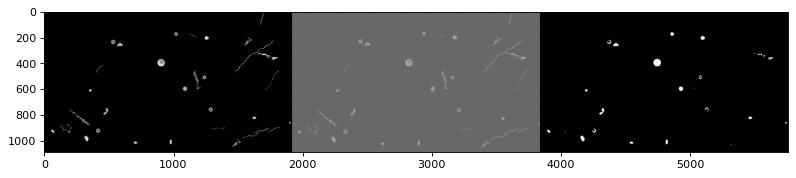

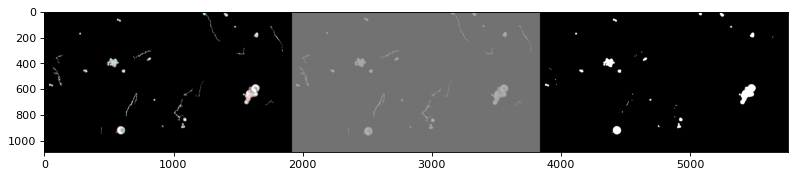

In [21]:
from matplotlib.pyplot import figure

y= model(Dataset)
predictions = y.cpu().detach().numpy()

for i,im in enumerate(predictions):
    img=cv2.cvtColor(im.squeeze(),cv2.COLOR_GRAY2RGB)
    img = cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    orig= np.array(Dataset[i].permute( 1, 2, 0))
    orig = cv2.normalize(orig, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    gt = np.array(groundtruth[i]).squeeze()
    gt =cv2.cvtColor(gt,cv2.COLOR_GRAY2RGB)
    gt = cv2.normalize(gt, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    
    horiz = np.concatenate((orig,img,gt),axis=1)
    
    figure(figsize=(12, 6), dpi=80)
    plt.imshow(horiz)
    plt.show()

In [ ]:

# TODO: the number of class labels was not specified correctly
Dataset = torch.tensor(dataS/255, dtype = torch.float, device = device).permute(0, 3, 1, 2)
Targets =  torch.tensor(targetS[:,None,:,:]/255, dtype = torch.float, device = device)
# Weights =  torch.tensor(weightS[:,None,:,:]/255, dtype = torch.float, device = device)
print(Targets.size())
running_loss = 0.0
for epoch in range(epochs):
    inputs = Dataset
    groundtruth = Targets

    optimizer.zero_grad()
    with autocast():
        outputs = model(inputs)
        loss = criterion( outputs, groundtruth)
#         loss = torch.mean(loss * Weights)
        
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    # print statistics
    running_loss += loss.item()
    print(f'[{epoch + 1}] loss: {running_loss / 100:.3f}')
    running_loss = 0.0


In [ ]:
# print(train_data_path)
# train_data_path =os.path.dirname(train_data_path)
# GROUND_MASK_DIR_PATH = train_data_path
# GROUND_MASK_DIR_PATH = os.path.join(os.path.dirname(train_data_path),"GT")


In [ ]:

# class arrDataset:
# #     normalize when loADING
#   def __init__(self, data_points_count= 2047):    
#     self.data_points_count= data_points_count
#     self.data = np.zeros((0, data_points_count))   
#     self.labels = np.zeros((0))
#     self.classes = {}
    
#   def add_items(self, data, labels):
#     data = data[:, 0:self.raman_points_count]
#     self.data = np.concatenate((self.data, data))
#     self.labels = np.concatenate((self.labels, labels))
    
#   def add_class(self, label, meas_class):
#     self.classes[label] =   meas_class

# def create_dataset(measurments,label, label_class):
#   dataset=Dataset()
#   measurments = [i for i in measurments if i is not None]
  
#   dataset.add_class(label, label_class)
  
#   for measurment in measurments:
#       dataset.add_items(np.array(measurment[None,:]),np.array([label]))
        
# #   print(dataset.get_data_shape())
#   return dataset

In [ ]:

#         if re.findall('.jpg$', imgPath)  :
#             path,ext  = os.path.splitext(imgPath)
#             file = os.path.basename(path)
#             dirPath = os.path.dirname(path)

#loss type                 input  target
#nn.MSELoss()              float, float
#nn.CrossEntropyLoss()     float, float 

In [ ]:
for parameter in model.parameters():
    print(parameter)